In [1]:
import numpy as np
import pandas as pd
import random
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [ ]:
!gdown https://drive.google.com/uc?id=1fnEA-6cPIgnLrbZa_jLyp7XSCgLvrFvF -O /content/train.zip

In [2]:
!pip install -q kaggle

In [3]:
# download api token from: https://www.kaggle.com/settings -> and upload here:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielhugauf","key":"0295a67482876b6105c9689eaf93ab20"}'}

In [4]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d nguyentuannguyen/optiver-trading-at-the-close

 97% 195M/201M [00:06<00:00, 45.0MB/s]
100% 201M/201M [00:06<00:00, 33.8MB/s]


In [8]:
!unzip optiver-trading-at-the-close.zip

Archive:  optiver-trading-at-the-close.zip
  inflating: optiver-trading-at-the-close/.idea/.gitignore  
  inflating: optiver-trading-at-the-close/.idea/inspectionProfiles/profiles_settings.xml  
  inflating: optiver-trading-at-the-close/.idea/jupyter-settings.xml  
  inflating: optiver-trading-at-the-close/.idea/misc.xml  
  inflating: optiver-trading-at-the-close/.idea/modules.xml  
  inflating: optiver-trading-at-the-close/.idea/optiver-trading-at-the-close.iml  
  inflating: optiver-trading-at-the-close/.idea/workspace.xml  
  inflating: optiver-trading-at-the-close/example_test_files/revealed_targets.csv  
  inflating: optiver-trading-at-the-close/example_test_files/sample_submission.csv  
  inflating: optiver-trading-at-the-close/example_test_files/test.csv  
  inflating: optiver-trading-at-the-close/optiver2023/__init__.py  
  inflating: optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: optiver-trading-at-the-close/optiver_stock_t

In [9]:
train_dataset = pd.read_csv('/content/optiver-trading-at-the-close/train.csv')
train_dataset.shape

(5237980, 17)

In [ ]:
train_dataset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [10]:
features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']#, 'near_price_norm', 'far_price_norm',
#             'volume', 'ask_ref_ratio', 'bid_ref_ratio', 'ask_imb_ratio', 'bid_imb_ratio', 'ask_mat_ratio', 'bid_mat_ratio']
# features = ['imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
#             'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'near_price', 'far_price']

In [11]:
train_dataset_drop = train_dataset[features+['target']].dropna()
train_dataset_drop.head()

,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,target
0,3180602.69,1,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,434.10,1.0,-7.349849


In [12]:
X = train_dataset_drop.drop(columns='target')
y = train_dataset_drop[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) #shuffle=False?
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4190208, 9) (1047552, 9)
(4190208, 1) (1047552, 1)


In [ ]:
# callbacks_list = [tf.keras.callbacks.EarlyStopping(
#                   monitor='val_loss',
#                   restore_best_weights=True,
#                   patience=5)]

# XGBRegressor

In [ ]:
xgb_model = XGBRegressor(
    booster = 'gbtree',
    objective='reg:absoluteerror',
    eval_metric = 'mae',
    n_estimators = 200,
    learning_rate = 0.1,
    colsample_bynode = 0.8,
    max_depth = 9,
    random_state= 42,
    verbosity=3,
    device='cuda'
)

In [ ]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_history = xgb_model.fit(X_train, y_train,
                            eval_set=eval_set)

[20:44:49] ======== Monitor (0): HostSketchContainer ========
[20:44:49] AllReduce: 0.023094s, 1 calls @ 23094us

[20:44:49] MakeCuts: 0.023159s, 1 calls @ 23159us

[20:44:49] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[20:44:49] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[20:44:50] ======== Monitor (0):  ========
[20:44:50] InitCompressedData: 0.000718s, 1 calls @ 718us

[20:44:50] ======== Monitor (0):  ========
[20:44:50] InitCompressedData: 0.000318s, 1 calls @ 318us

[0]	validation_0-mae:6.39310	validation_1-mae:6.41020
[1]	validation_0-mae:6.38414	validation_1-mae:6.40150
[2]	validation_0-mae:6.37648	validation_1-mae:6.39417
[3]	validation_0-mae:6.37039	validation_1-mae:6.38834
[4]	validation_0-mae:6.36534	validation_1-mae:6.38351
[5]	validation_0-mae:6.36079	validation_1-mae:6.37918
[6]	validation_0-mae:6.35702	validation_1-mae:6.37559
[7]	validation_0-mae:6.35335	validation_1-mae:6.37220
[8]	validation_0-mae:6.35038	validation_1

# XGBRegressor metrics

In [ ]:
pred_y = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test,pred_y)
print(f"XGBoost's MAE is {mae_xgb:.3f}")

[20:37:36] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[20:37:36] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
XGBoost's MAE is 6.322


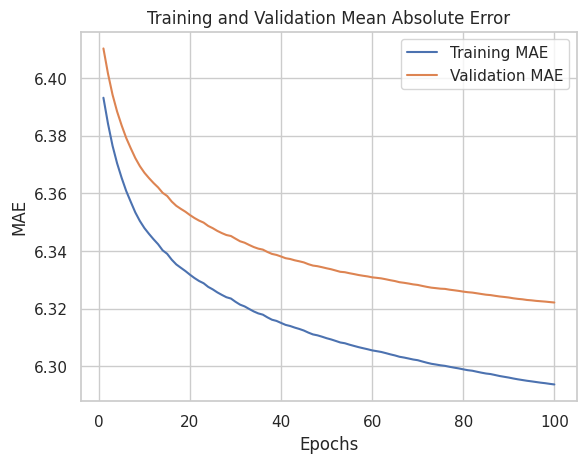

In [ ]:
results = xgb_history.evals_result()
epochs = len(results['validation_0']['mae'])

# Extract the MAE information from results
train_mae = results['validation_0']['mae']
val_mae = results['validation_1']['mae']

# Plotting the training and validation MAE
plt.plot(range(1, epochs + 1), train_mae, label='Training MAE')
plt.plot(range(1, epochs + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

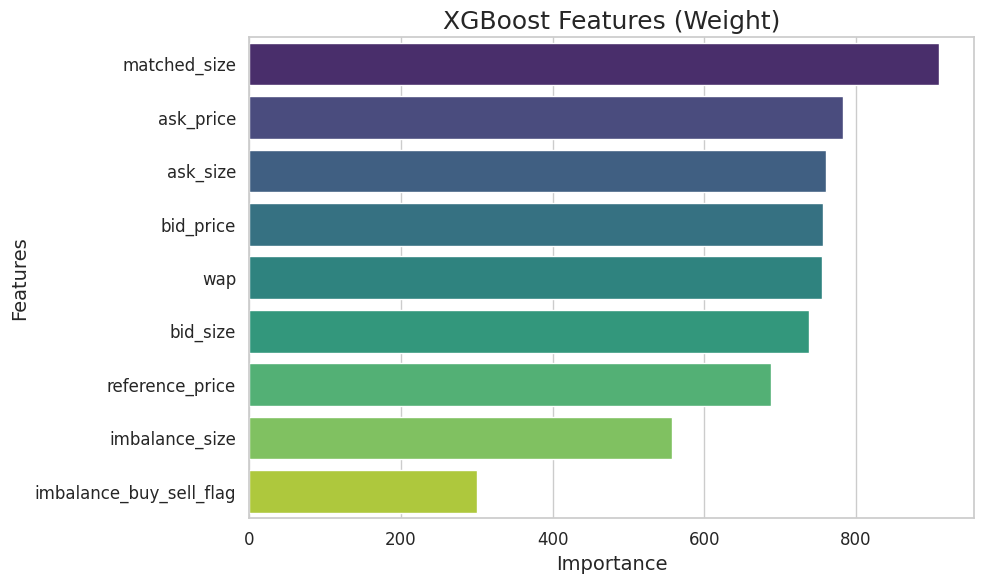

In [ ]:
metric = 'weight'  # weight, gain, cover, total_gain, total_cover
imp = xgb_model.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp, index=['score']).T.sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=14)
f.set_ylabel("Features", fontsize=14)
f.tick_params(labelsize=12)
plt.title(f'XGBoost Features ({metric.capitalize()})', fontsize=18)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

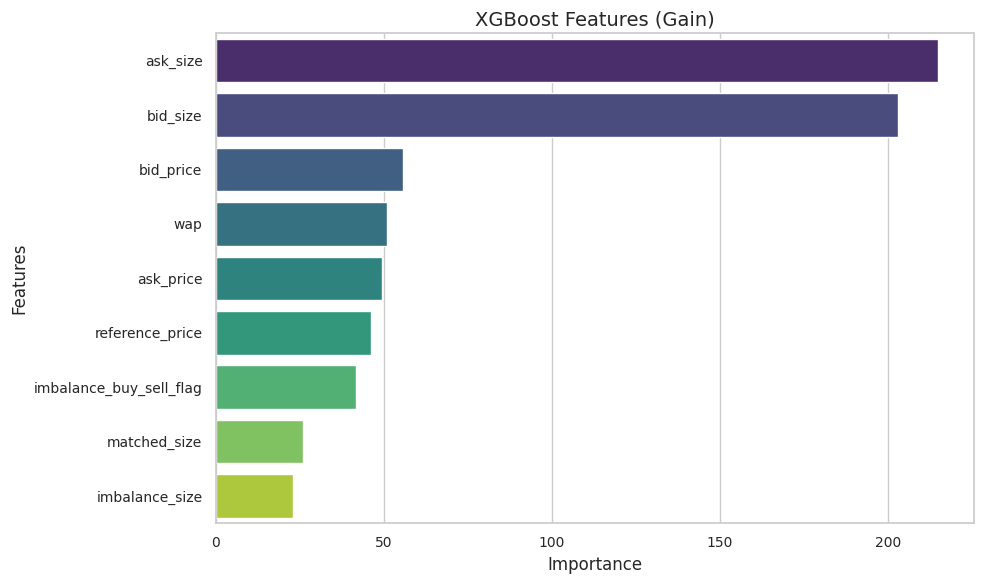

In [ ]:
metric = 'gain'  # weight, gain, cover, total_gain, total_cover
imp = xgb_model.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp, index=['score']).T.sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'XGBoost Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

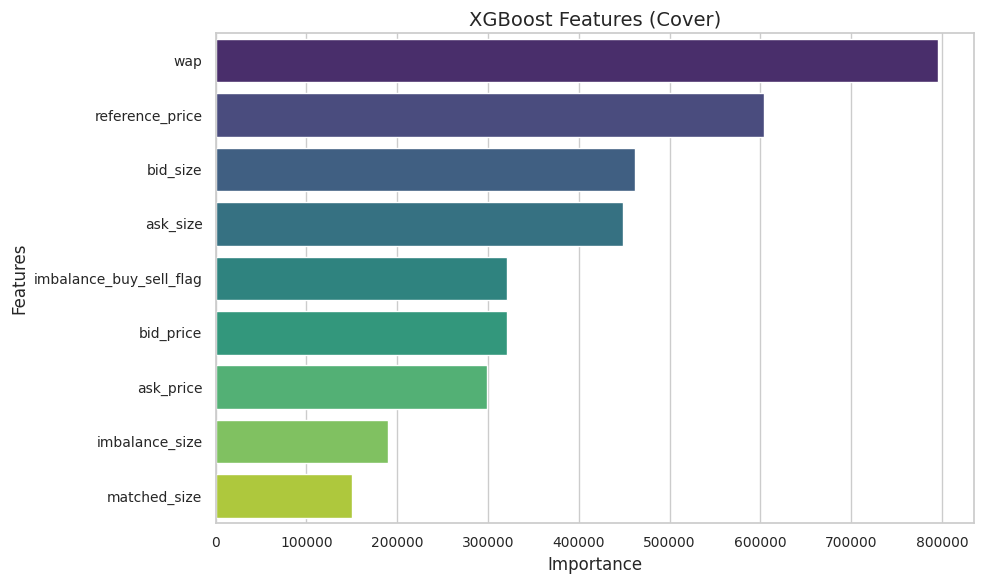

In [ ]:
metric = 'cover'  # weight, gain, cover, total_gain, total_cover
imp = xgb_model.get_booster().get_score(importance_type=metric)
feature_importance = pd.DataFrame(imp, index=['score']).T.sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'XGBoost Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

# LGBMRegressor

In [ ]:
lgb_model = LGBMRegressor(
    boosting_type = 'gbdt',
    objective='mae',
    learning_rate = 0.1,
    n_estimators = 100,
    num_leaves = 75,
    colsample_bytree = 0.8,
    random_state=42,
    verbosity=2,
) # gpu?

In [ ]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ["Training MAE", "Validation MAE"]

lgb_history = lgb_model.fit(X_train, y_train,
                            eval_set=eval_set,
                            eval_names=eval_names)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.047983
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.242574 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 4190208, number of used features: 9
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 10
[LightGBM] [Debug] Trained a tree with le

# LGBMRegressor metrics

In [ ]:
pred_y = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test,pred_y)
print(f"LightGBM's MAE is {mae_lgb:.3f}")

LightGBM's MAE is 6.324


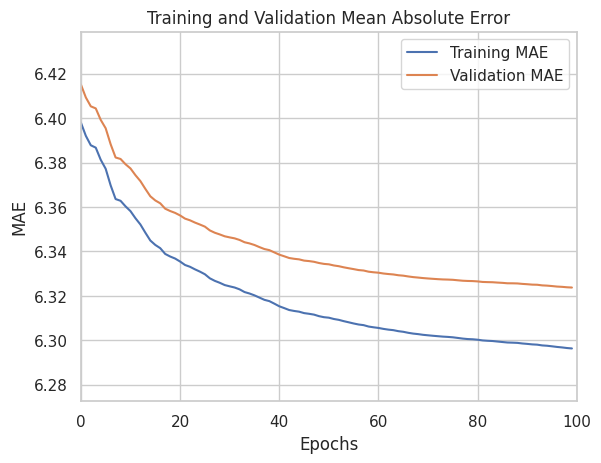

In [ ]:
ax = lgb.plot_metric(lgb_model, metric='l1')  # 'l1' is equivalent to 'mae'
ax.set_title('Training and Validation Mean Absolute Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE')
plt.show()

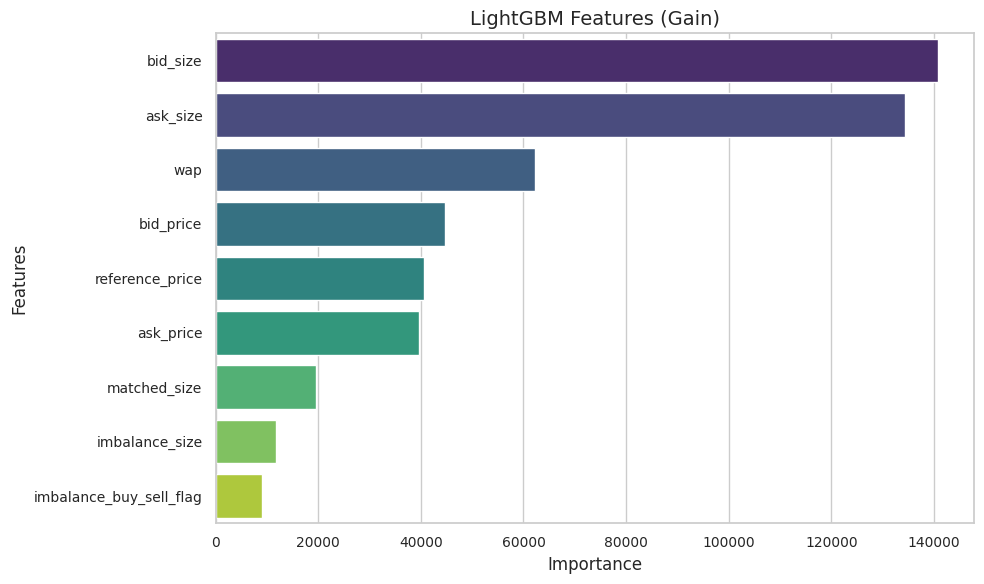

In [ ]:
metric = 'gain'
imp = lgb_model.booster_.feature_importance(importance_type=metric)
features = lgb_model.booster_.feature_name()

feature_importance = pd.DataFrame(imp, index=features, columns=['score']).sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'LightGBM Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

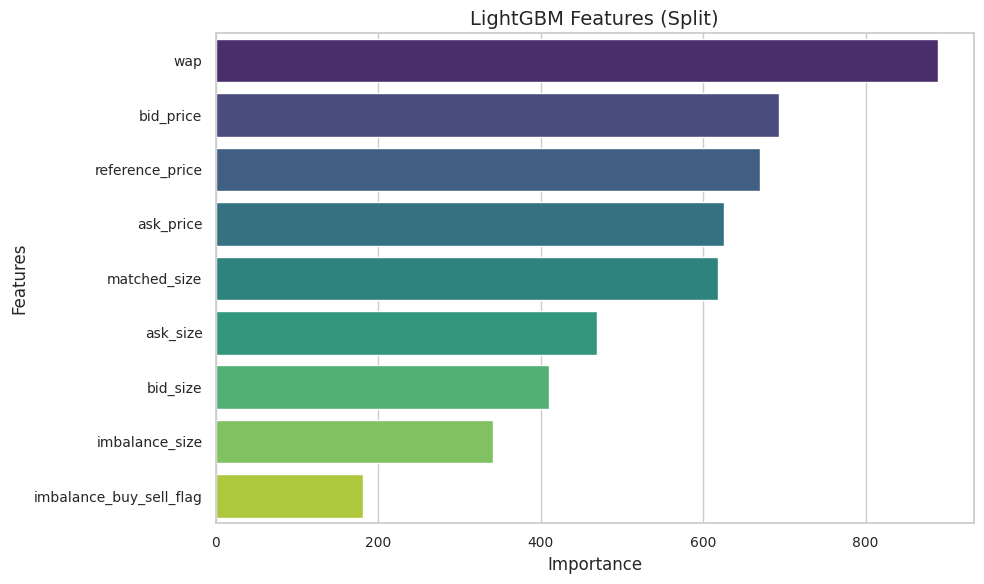

In [ ]:
metric = 'split'
imp = lgb_model.booster_.feature_importance(importance_type=metric)
features = lgb_model.booster_.feature_name()

feature_importance = pd.DataFrame(imp, index=features, columns=['score']).sort_values('score', ascending=False)
feature_importance.reset_index(inplace=True)
feature_importance.columns = ['Features', 'Importance']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
f = sns.barplot(x="Importance", y="Features", data=feature_importance, hue="Features", palette="viridis", dodge=False)
f.set_xlabel("Importance", fontsize=12)
f.set_ylabel("Features", fontsize=12)
f.tick_params(labelsize=10)
plt.title(f'LightGBM Features ({metric.capitalize()})', fontsize=14)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

# Testing

In [ ]:
gc.collect()

In [ ]:
pred_y_xgb = xgb_model.predict(X_test)
pred_y_lgb = lgb_model.predict(X_test)
print(pred_y_xgb[:5])
print(pred_y_lgb[:5])
print(y_test.head(5).values.reshape(1, -1).flatten())

[ 0.3088617   0.08125901 -1.9137045   0.49081135 -0.06022178]
[ 0.10213349  0.04361877 -1.85275906  0.62969331 -0.05006309]
[-35.83014    -2.7900934  -2.629757   -9.729862   -5.519986 ]


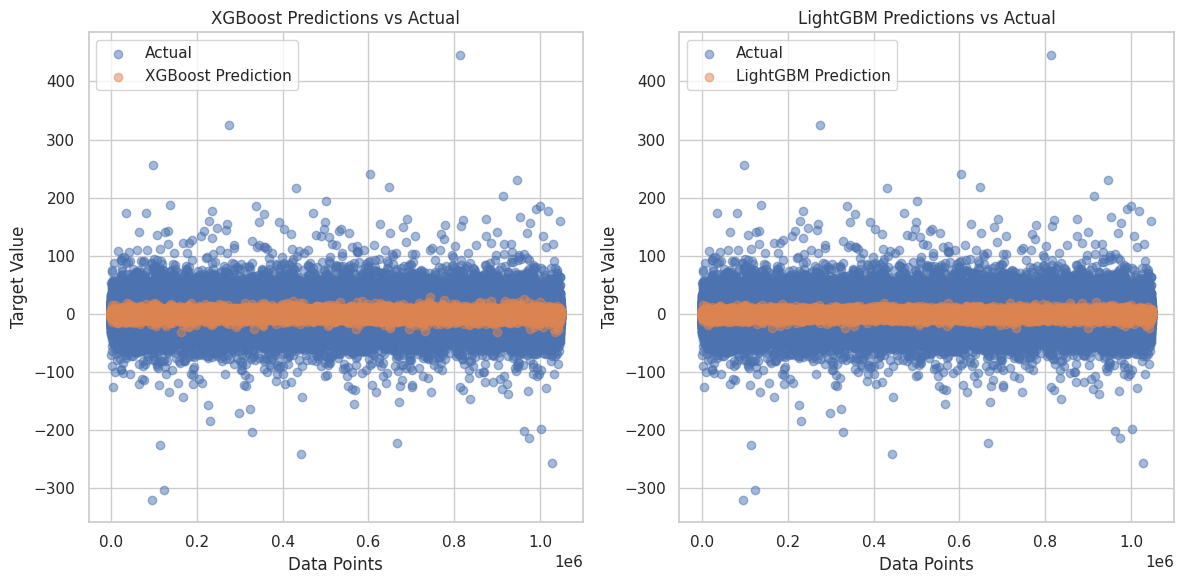

In [ ]:
# Plot for all of the datapoints

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', alpha=0.5)
plt.scatter(np.arange(len(pred_y_xgb)), pred_y_xgb, label='XGBoost Prediction', alpha=0.5)
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', alpha=0.5)
plt.scatter(np.arange(len(pred_y_lgb)), pred_y_lgb, label='LightGBM Prediction', alpha=0.5)
plt.title('LightGBM Predictions vs Actual')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

plt.tight_layout()
plt.show()

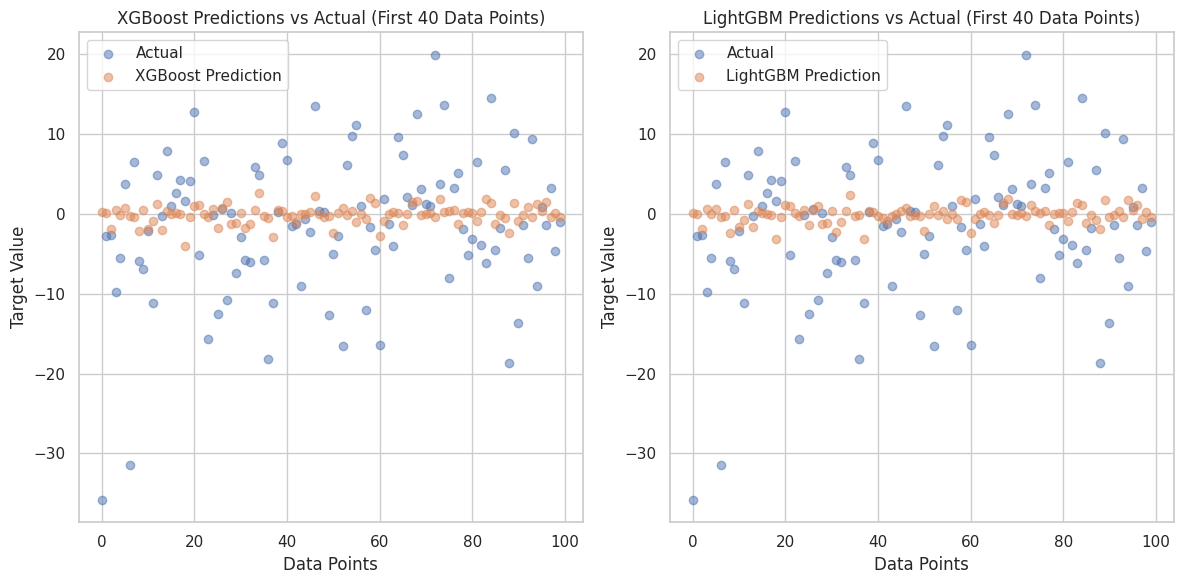

In [ ]:
# Plot for the first 100 datapoints

num_points = 100

# Plotting the XGBoost predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(num_points), y_test[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_xgb[:num_points], label='XGBoost Prediction', alpha=0.5)
plt.title('XGBoost Predictions vs Actual (First 40 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

# Plotting the LightGBM predictions
plt.subplot(1, 2, 2)
plt.scatter(np.arange(num_points), y_test[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_lgb[:num_points], label='LightGBM Prediction', alpha=0.5)
plt.title('LightGBM Predictions vs Actual (First 40 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

plt.tight_layout()
plt.show()


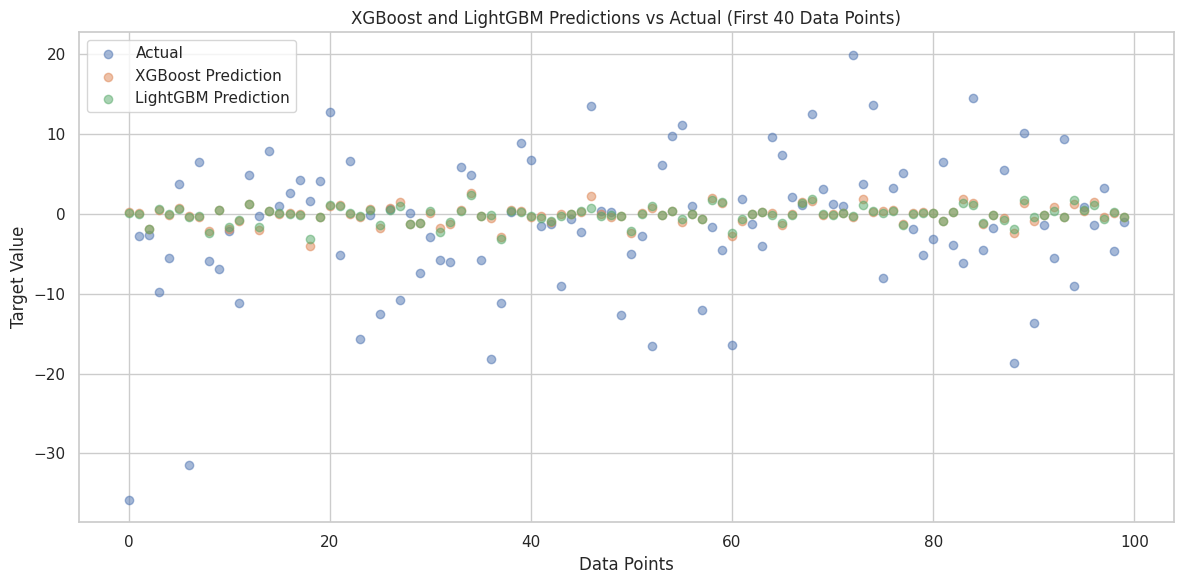

In [ ]:
# Plot for the first 100 datapoints with both models on the same graph

num_points = 100

plt.figure(figsize=(12, 6))
plt.scatter(np.arange(num_points), y_test[:num_points], label='Actual', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_xgb[:num_points], label='XGBoost Prediction', alpha=0.5)
plt.scatter(np.arange(num_points), pred_y_lgb[:num_points], label='LightGBM Prediction', alpha=0.5)

plt.title('XGBoost and LightGBM Predictions vs Actual (First 40 Data Points)')
plt.xlabel('Data Points')
plt.ylabel('Target Value')
plt.legend()

plt.tight_layout()
plt.show()


# Gridsearch

## XGBRegressor

In [13]:
gc.collect()

0

In [ ]:
bst_xgb = XGBRegressor(
    booster='gbtree',
    objective='reg:absoluteerror',
    eval_metric='mae',
    random_state=42,
    verbosity=2,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'n_estimators' : (50, 100, 200),
    'learning_rate': (0.001, 0.01, 0.1, 0.5),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_xgb, hyperparameters, scoring=score, cv=tscv, verbose=2
)

In [ ]:
%%time
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[21:43:40] ======== Monitor (0): HostSketchContainer ========
[21:43:40] AllReduce: 0.029904s, 1 calls @ 29904us

[21:43:40] MakeCuts: 0.03577s, 1 calls @ 35770us

[21:43:40] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[21:43:40] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[21:43:41] ======== Monitor (0):  ========
[21:43:41] InitCompressedData: 0.000263s, 1 calls @ 263us

[21:43:41] ======== Monitor (0): Learner ========
[21:43:41] Configure: 0.001844s, 1 calls @ 1844us

[21:43:41] EvalOneIter: 0.000363s, 50 calls @ 363us

[21:43:41] GetGradient: 0.154108s, 50 calls @ 154108us

[21:43:41] PredictRaw: 0.000394s, 50 calls @ 394us

[21:43:41] UpdateOneIter: 0.932828s, 50 calls @ 932828us

[21:43:41] ======== Monitor (0): GBTree ========
[21:43:41] BoostNewTrees: 0.614253s, 50 calls @ 614253us

[21:43:41] CommitModel: 5.2e-05s, 50 calls @ 52us

[21:43:41] ======== Device 0 Memory A

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

{'learning_rate': 0.1, 'n_estimators': 200}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

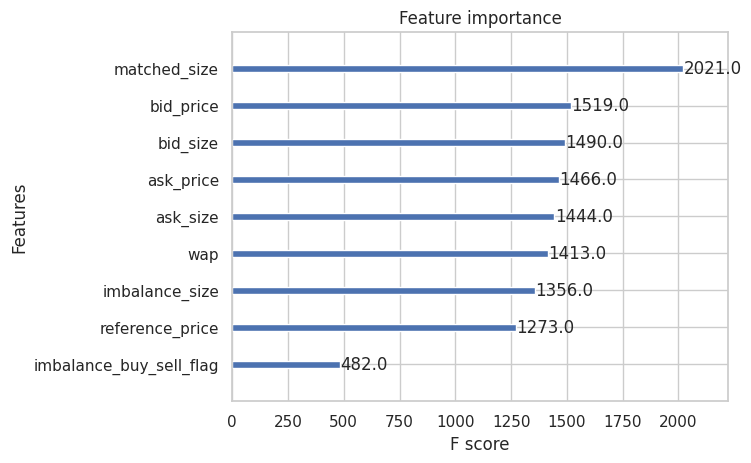

In [ ]:
display(grid_search.best_estimator_)
display(grid_search.best_params_)
xgb.plot_importance(grid_search.best_estimator_,max_num_features=30)

In [14]:
bst_xgb = XGBRegressor(
    booster='gbtree',
    objective='reg:absoluteerror',
    eval_metric='mae',
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    verbosity=2,
    device='cuda'
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'max_depth' : (3, 6, 9),
    'colsample_bynode':(0.5, 0.65, 0.8),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_xgb, hyperparameters, scoring=score, cv=tscv, verbose=2
)

In [15]:
%%time
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:02:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=   4.1s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=   6.6s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=   7.9s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=  11.8s
[CV] END ..................colsample_bynode=0.5, max_depth=3; total time=  16.8s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=   4.1s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=   7.7s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=   9.1s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=  13.0s
[CV] END ..................colsample_bynode=0.5, max_depth=6; total time=  16.6s
[CV] END ..................colsample_bynode=0.5, max_depth=9; total time=   7.2s
[CV] END ..................colsample_bynode=0.5, max_depth=9; total time=   9.2s
[CV] END ..................c

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.8,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

{'colsample_bynode': 0.8, 'max_depth': 9}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

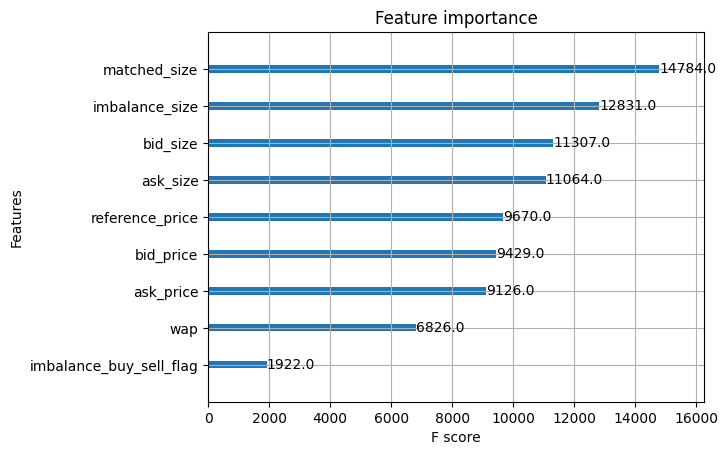

In [16]:
display(grid_search.best_estimator_)
display(grid_search.best_params_)
xgb.plot_importance(grid_search.best_estimator_,max_num_features=30)

## LGBMRegressor

In [17]:
gc.collect()

0

In [20]:
bst_lgb = LGBMRegressor(
    boosting_type='gbdt',
    objective='mae',
    random_state=42,
    verbosity=1,
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'n_estimators' : (50, 100, 200),
    'learning_rate': (0.001, 0.01, 0.1, 0.5),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_lgb, hyperparameters, scoring=score, cv=tscv, verbose=2
)

In [21]:
%%time
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 698368, number of used features: 9
[LightGBM] [Info] Start training from score -0.060201
[CV] END ...............learning_rate=0.001, n_estimators=50; total time=   5.6s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 1396736, number of used features: 9
[LightGBM] [Info] Start training from score -0.060201
[CV] END ...............learning_rate=0.001, n_estimators=50; total time=  15.7s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.05

{'learning_rate': 0.1, 'n_estimators': 200}

LGBMRegressor(n_estimators=200, objective='mae', random_state=42, verbosity=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

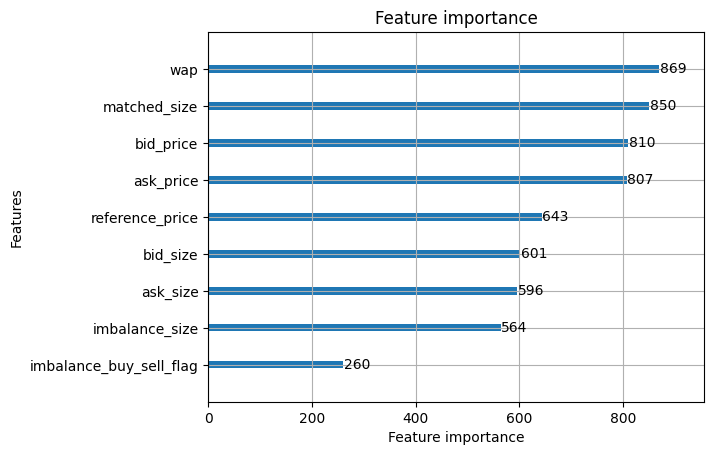

In [22]:
display(grid_search.best_params_)
display(grid_search.best_estimator_)
lgb.plot_importance(grid_search.best_estimator_,max_num_features=25)

In [23]:
bst_lgb = LGBMRegressor(
    boosting_type='gbdt',
    objective='mae',
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
)

tscv = TimeSeriesSplit(n_splits=5)

hyperparameters = {
    'num_leaves':       (25, 50, 75),
    'colsample_bynode': (0.5, 0.65, 0.8),
}

score = 'neg_mean_absolute_error'
grid_search = GridSearchCV(
    bst_lgb, hyperparameters, scoring=score, cv=tscv,verbose=2
)

In [24]:
%%time
grid_search.fit(X_train, y_train)
print(f'Grid search best MAE: {grid_search.best_score_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 698368, number of used features: 9
[LightGBM] [Info] Start training from score -0.060201
[CV] END ................colsample_bynode=0.5, num_leaves=25; total time=  16.3s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 1396736, number of used features: 9
[LightGBM] [Info] Start training from score -0.060201
[CV] END ................colsample_bynode=0.5, num_leaves=25; total time=  27.4s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.295

{'colsample_bynode': 0.8, 'num_leaves': 75}

LGBMRegressor(colsample_bynode=0.8, n_estimators=200, num_leaves=75,
              objective='mae', random_state=42)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

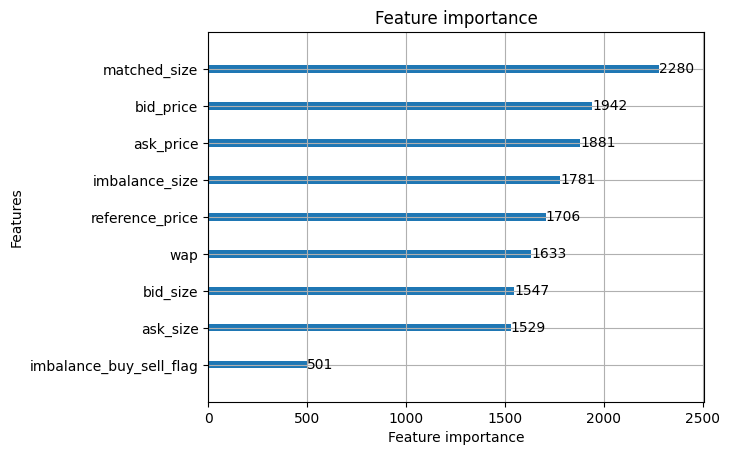

In [25]:
display(grid_search.best_params_)
display(grid_search.best_estimator_)
lgb.plot_importance(grid_search.best_estimator_,max_num_features=25)